### FOF-KD Tree Implementation

In [1]:
import os; os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='1.' # NOTE: jax preallocates GPU (default 75%)

os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '1'


In [2]:
import fof.fofkd as fof
from fof.utils import *
import time
import numpy as np
import gc

In [3]:


#quick test with lognormal mocks...
for nn,pnum in enumerate([787121,7887677,78851677]):
    pos = np.load("./example_data/log_norm_"+str(pnum)+".npy").astype(np.float32)
    for i in range(5):
        st = time.time()
        d = (1380**3/pos.shape[0])**(1/3)
        #force fp32 & GPU placement for CUDA kernels
        pos32 = jnp.array(pos, dtype=jnp.float32, copy=True)
        pos32 = jax.device_put(pos32, jax.devices("gpu")[0])
        #some irregular behaviour with the cuda kernel, might be due to blocking...
        fof_output_fast = fof.fof_clusters_jit(
            pos32, b=float(0.2*d), k=int(8), max_iters=int(100), cuda=False
        )
        print(pnum, i,time.time()-st)
        #not really sure these help or are useful...
        del fof_output_fast
        gc.collect()

787121 0 5.340936899185181
787121 1 0.7135546207427979
787121 2 0.7047693729400635
787121 3 0.7022407054901123
787121 4 0.7023658752441406
7887677 0 14.736628293991089
7887677 1 10.63225531578064
7887677 2 10.674525499343872
7887677 3 10.666207313537598
7887677 4 10.649513244628906
78851677 0 207.1604790687561
78851677 1 204.63479042053223
78851677 2 204.6405427455902
78851677 3 204.50175261497498
78851677 4 204.62583422660828


In [5]:
#timing is a bit strange... but fast anyway... 
#Not sure why jit compilation makes things FASTER for cuda kernel 

### Test on Camels

Very nonlinear structure changes performance characteristics due to convergence...

In [6]:
#test on camels
import h5py
import fof.fofkd_exp as fof_e


In [12]:
fof_e.fof_fn

<function fof.fofkd_exp.wrap_pos_arg.<locals>._call(pos)>

In [7]:
file = h5py.File("/home/ben.horowitz/sims/camels/example_cv0/snapshot_090.hdf5.1","r")

In [8]:
coord = file["PartType1"]['Coordinates']

In [14]:
particles = coord[:][::1]

In [15]:
particles.min(),particles.max() #particles are in units of Kpc

(np.float32(0.00023776187), np.float32(24999.998))

In [41]:
d = (25**3/particles.shape[0])**(1/3)

#for whatever reason, the "bare bones" fof implementation sometimes hangs using cuda, 
#but the more complex implementation (with ChatGPT help) seems to work well....

fof_fn = fof_e.make_fof_frozen(k=8, max_iters=300, min_size=5, b=0.20*0.95*d, cuda=True)

fof_fn = fof_e.wrap_pos_arg(fof_fn)

In [51]:
import fof.fofkd_exp as fof_e
d = (25**3/particles.shape[0])**(1/3)
for i in range(1):
    st = time.time()
    out = fof_fn(particles/1000)
    print(particles.shape[0], i, time.time()-st)
    out[0].block_until_ready()          # if out is a JAX Array
    #Blocking is sometimes problematic...
    print(particles.shape[0], i, time.time() - st)
   # del out
    #might kill kernel with repeated loops?

16777216 0 1.0939078330993652
16777216 0 4.074495315551758


0.09765625000000001

In [52]:
print("hi!")

hi!


In [53]:
out.labels

Array([ 0,  0,  0, ..., -1, -1, -1], dtype=int32)

In [54]:
j_pos, j_masses = cluster_centers_masses_padded(particles/1000,out.labels)


In [55]:
mass_filt = j_masses>5

In [56]:
j_masses[np.argpartition(j_masses,-4)[-4:]]

Array([281625., 320296., 331058., 680144.], dtype=float32)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


Text(0, 0.5, 'Number')

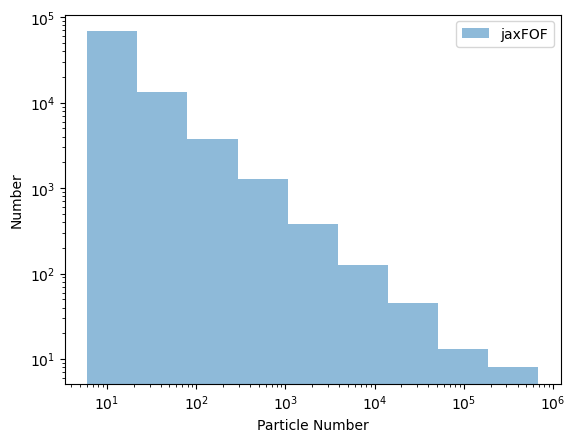

In [57]:
%pylab inline

logbins = np.logspace(np.log10((j_masses[mass_filt]).min()),np.log10((j_masses[mass_filt]).max()),10)

_,bins, _ = plt.hist(j_masses[mass_filt],alpha=0.5,bins=logbins,label="jaxFOF")
plt.loglog()
plt.legend()
plt.xlabel("Particle Number")
plt.ylabel("Number")

In [58]:
ids = np.argpartition(j_masses,-4)[-20:]

63385


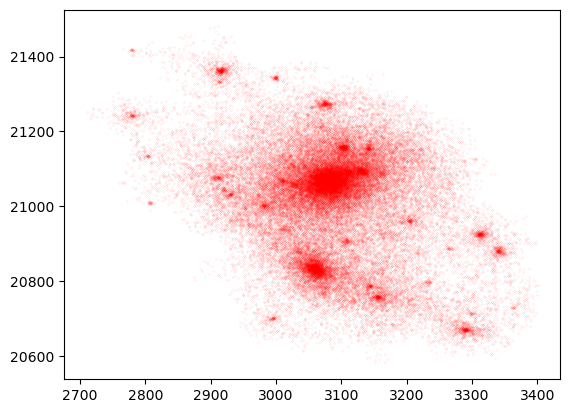

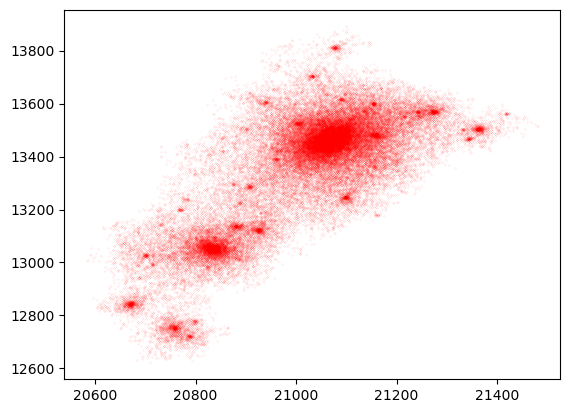

67301


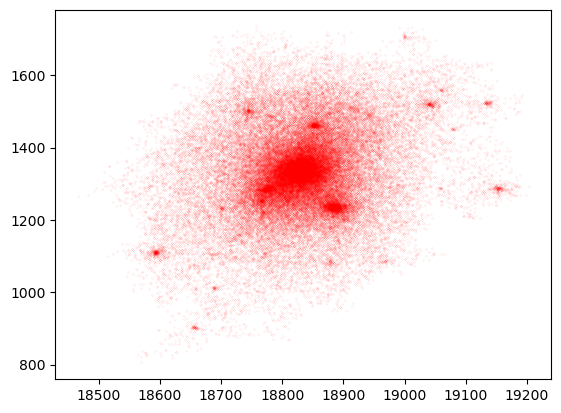

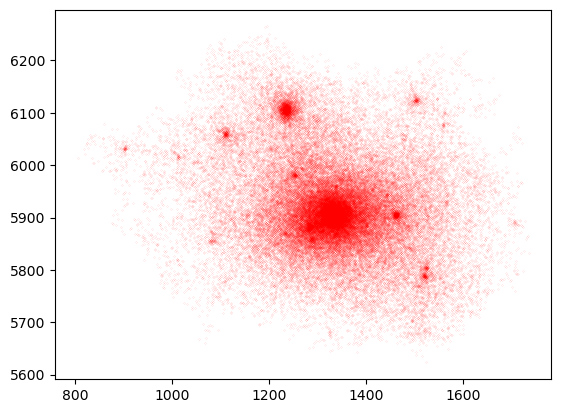

72317


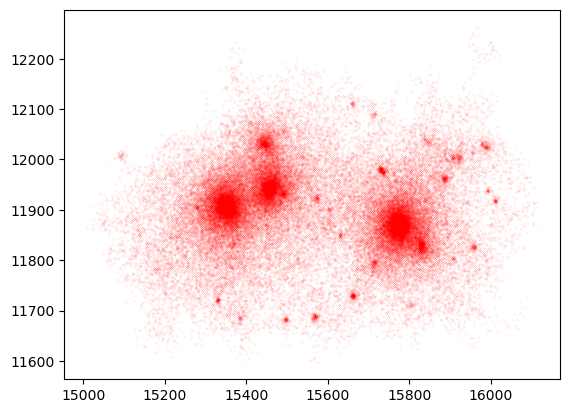

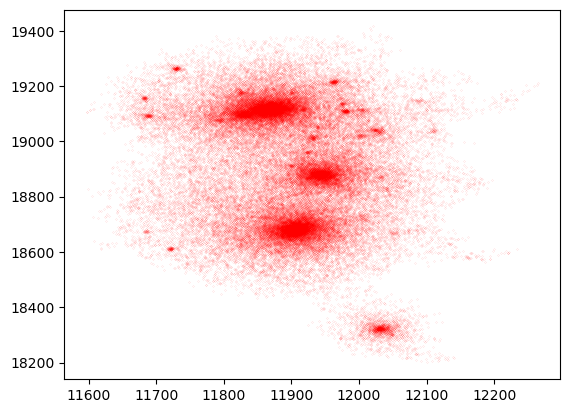

76196


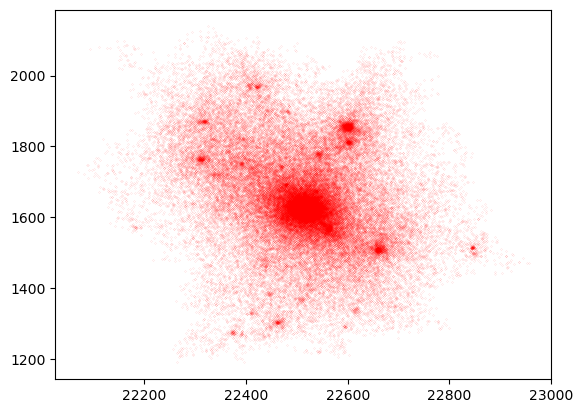

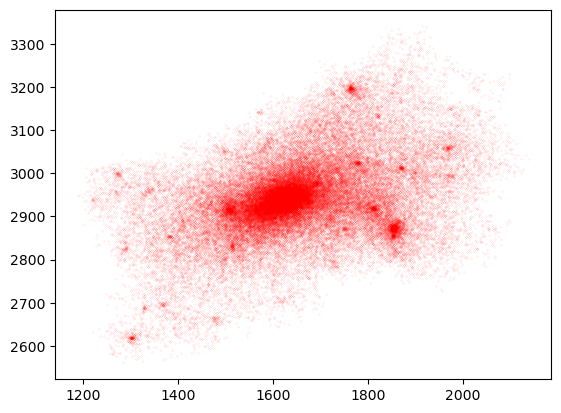

84742


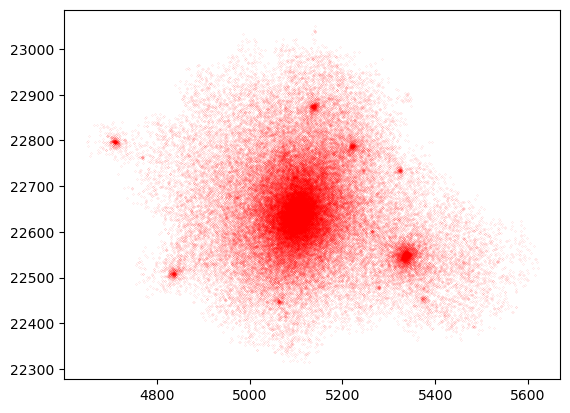

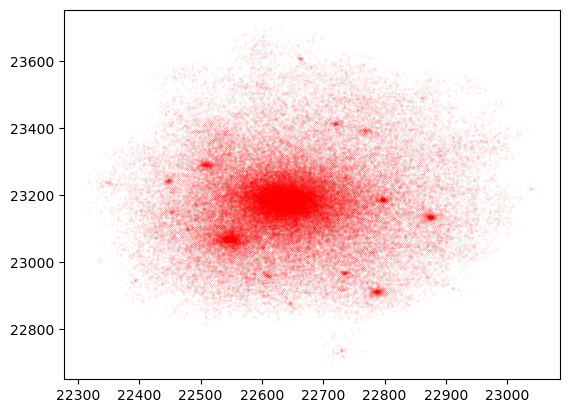

87075


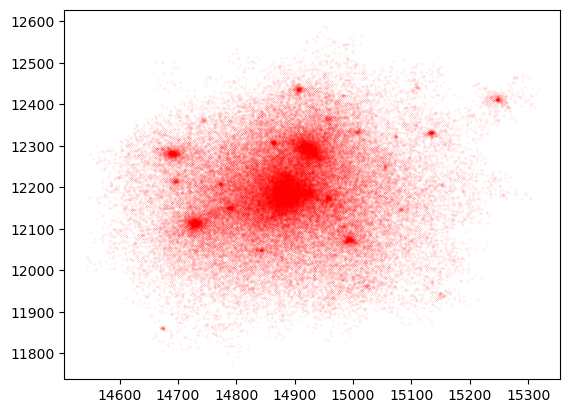

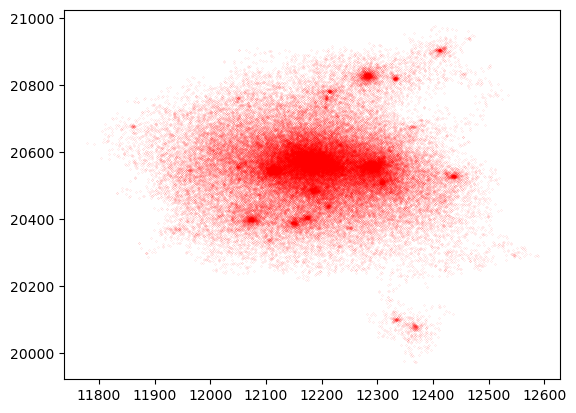

88899


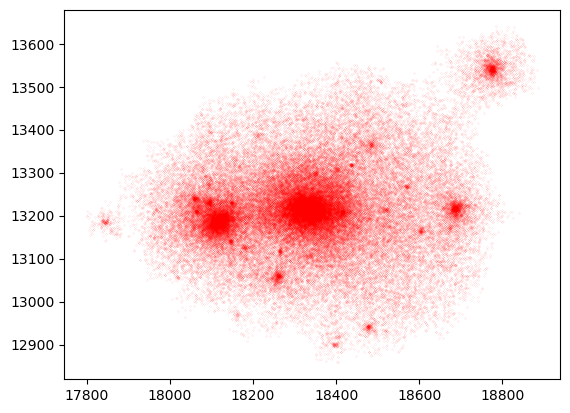

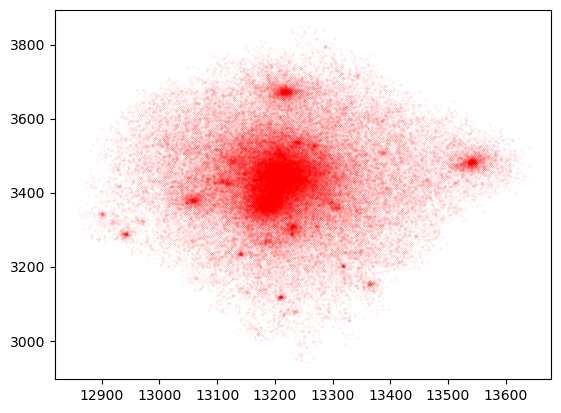

90015


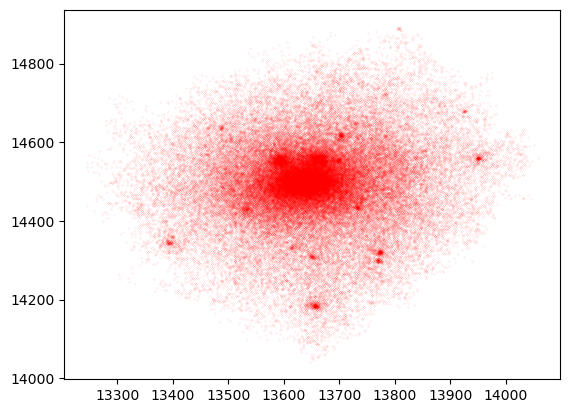

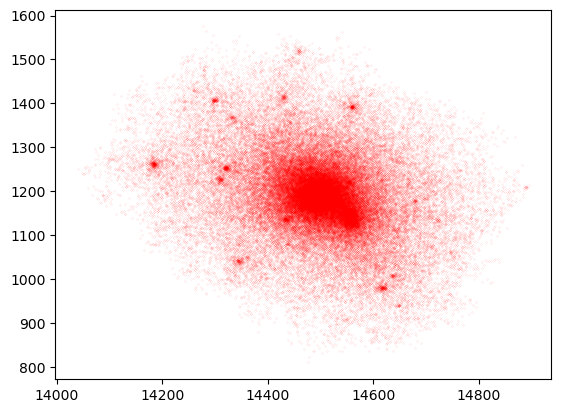

90962


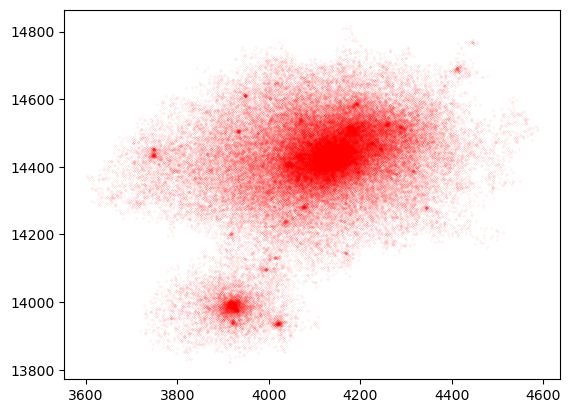

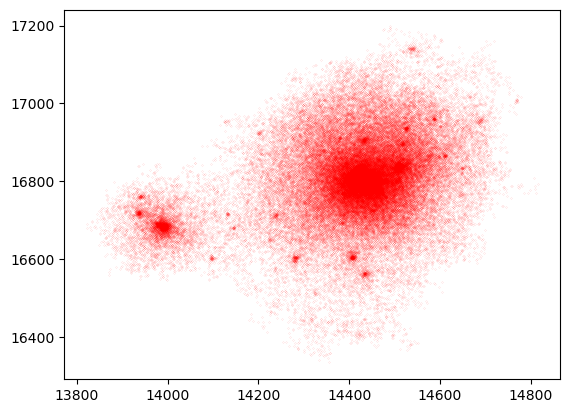

91117


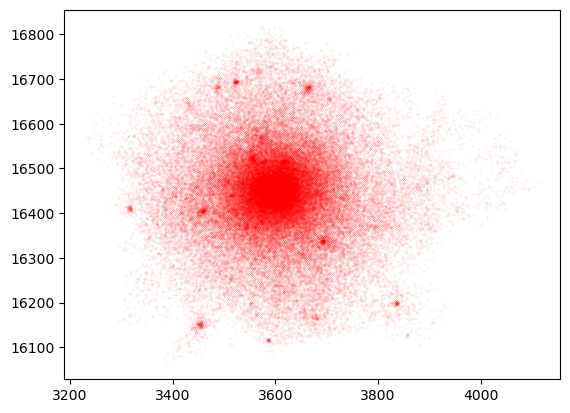

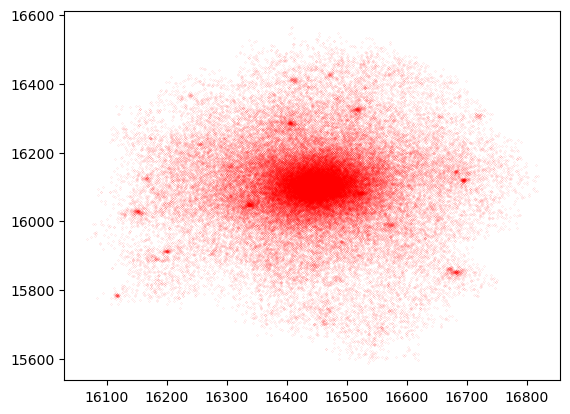

93030


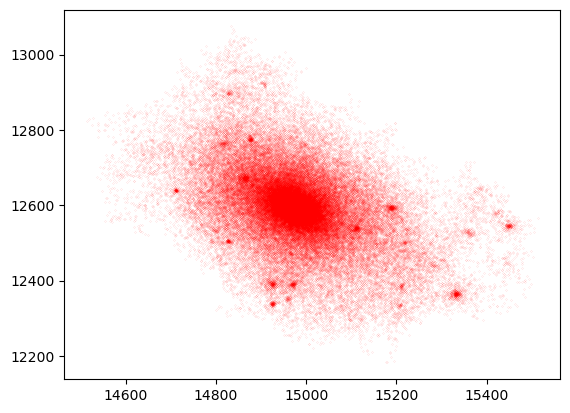

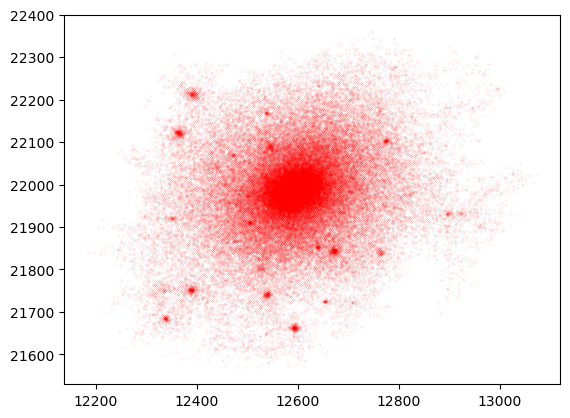

147057


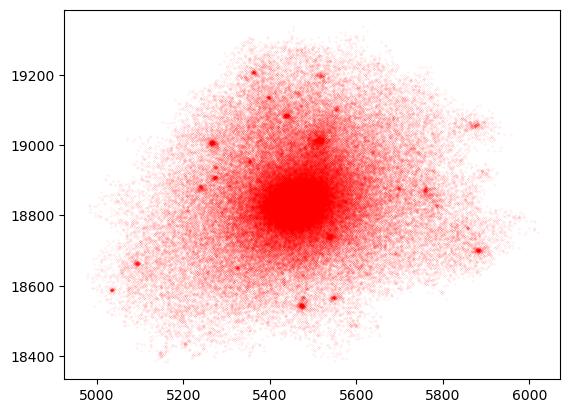

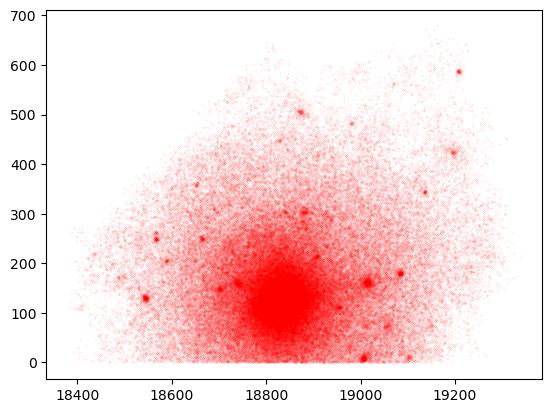

203046


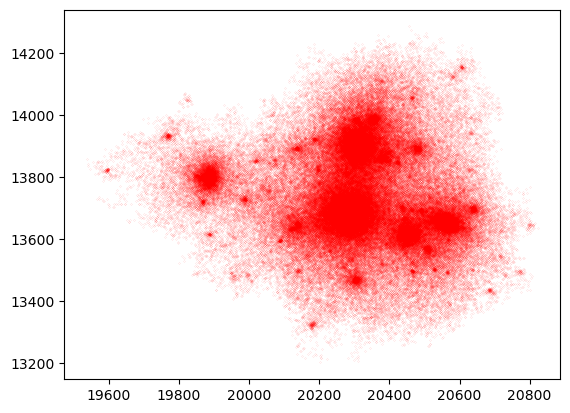

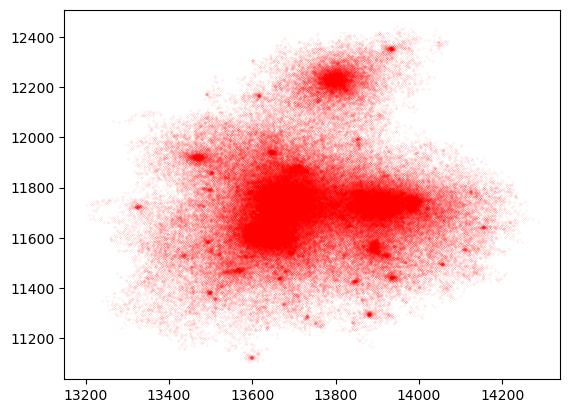

223935


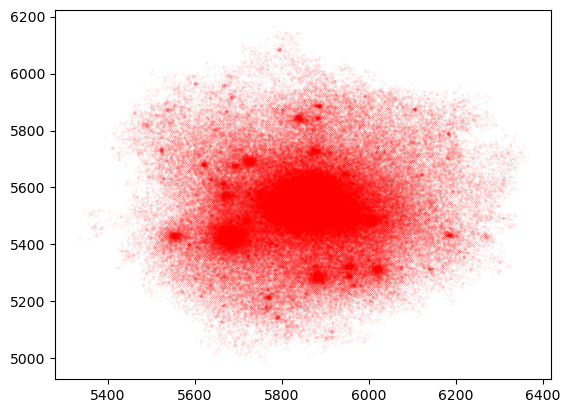

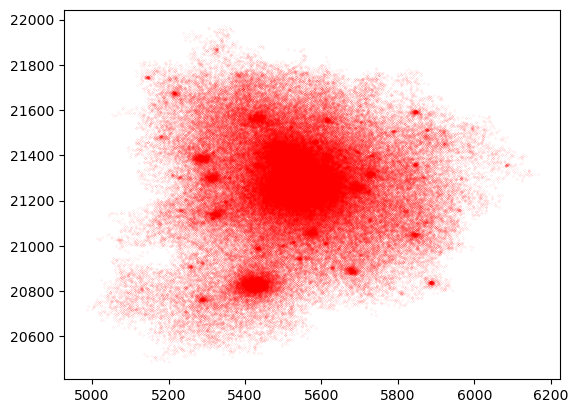

264923


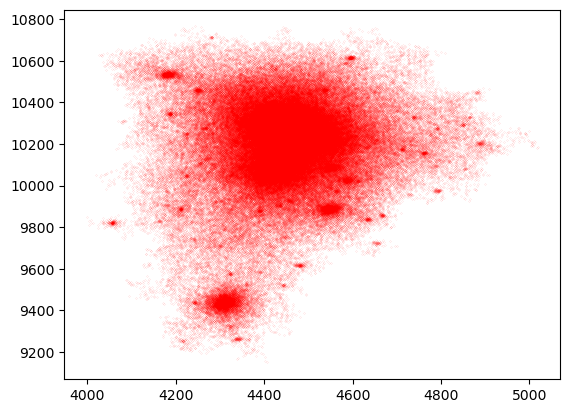

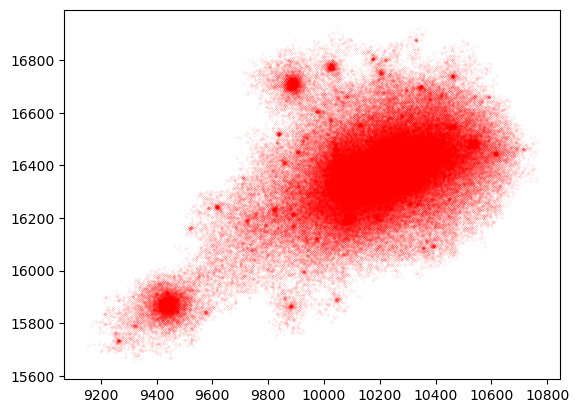

266861


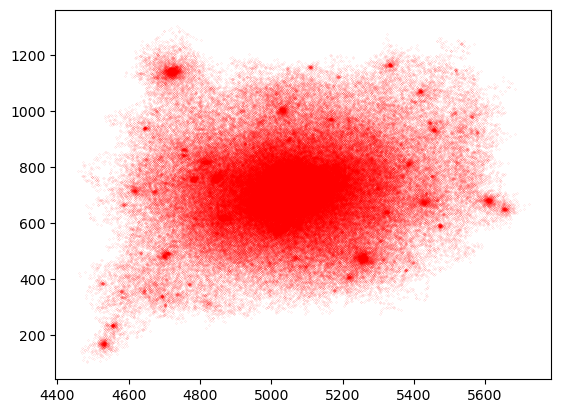

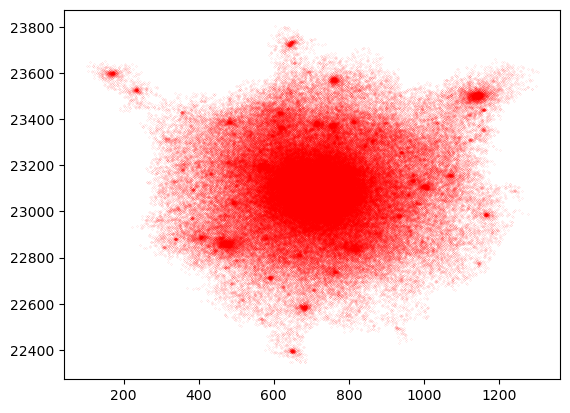

281625


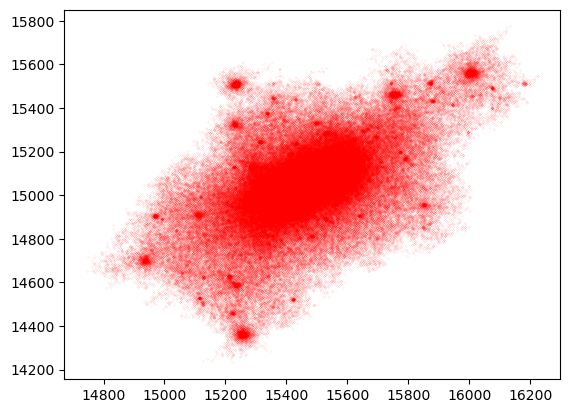

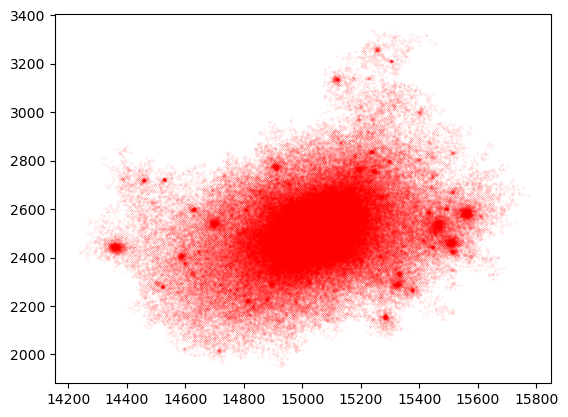

320296


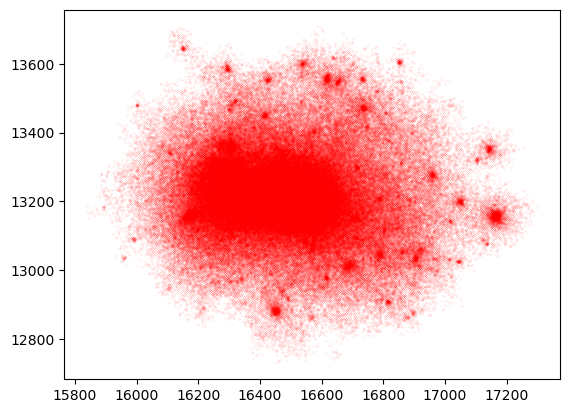

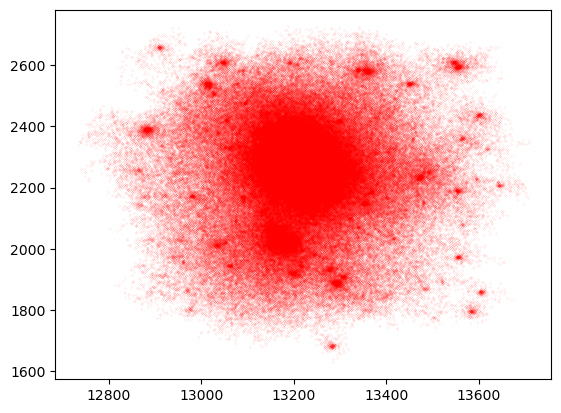

331058


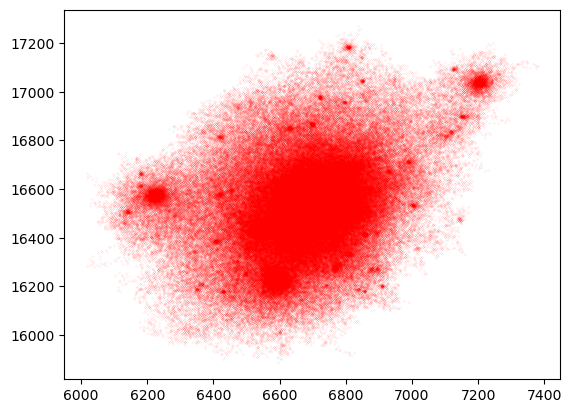

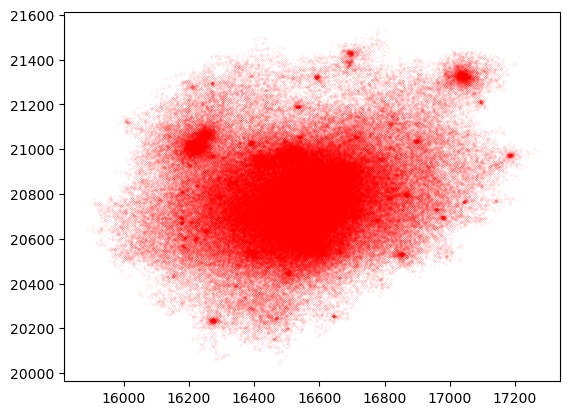

680144


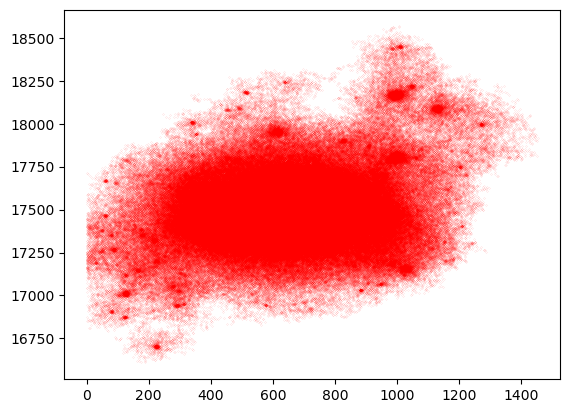

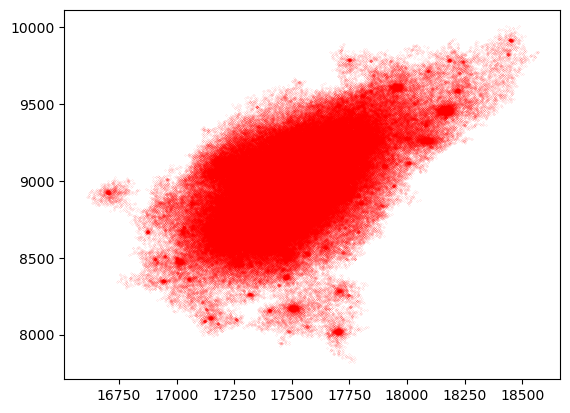

In [59]:
for halo_id in ids:
    print(np.sum(out.labels==halo_id))
    plt.plot(particles[out.labels==halo_id][:,0],particles[out.labels==halo_id][:,1],"r.",markersize=0.1)
    plt.show()
    plt.plot(particles[out.labels==halo_id][:,1],particles[out.labels==halo_id][:,2],"r.",markersize=0.1)
    plt.show()

In [60]:
#notice edge effects!